In [2]:
import torch
import torch.nn as nn

x = torch.rand(1, 3, 52, 52)
conv = nn.Conv2d(3, 256, kernel_size=1,stride=1,padding=1)
y = conv(x)
print(y.shape)

torch.Size([1, 256, 54, 54])


In [8]:
import json
with open("/scr1/li108/data/annotations/person_keypoints_train2017.json") as f:
    y = json.load(f)
print(y['categories'])

[{'supercategory': 'person', 'id': 1, 'name': 'person', 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]}]


In [9]:
y.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [40]:
y['annotations'][0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [17]:
#y['annotations'][0]['segmentation'][0]

In [53]:
# get coco dataset 
import json
with open("/home/hongshan/data/annotations/instances_train2017.json") as f:
    z = json.load(f)


In [11]:
z.keys()
z['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [46]:
i = 0
for img in z['images']:
    if img['height'] > 640 or img['width'] > 640:
        i=i+1
        print(img['file_name'], img['width'], img['height'])
print("irregular imgs:", i)

irregular imgs: 0


In [50]:
z['annotations'][0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os.path as osp
data_dir = '/scr1/li108/data'
coco_data = datasets.CocoDetection(root=osp.join(data_dir,'coco_train_2017'),
                          annFile=osp.join(data_dir, 'annotations',
                                          'instances_train2017.json'),
                    
                          )


loading annotations into memory...
Done (t=9.80s)
creating index...
index created!


In [11]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
import numpy as np


def compute_iou(rec1, rec2):
    '''
    Given two rectangles rec1 and rec2 
    computes its iou
    
    Args:
        rec1: tensor of shape B x 4
        First dim is the batch size;
        Second dim is the top-left coordinate,
        width and height
    '''
    # check type and dim of rec1 and rec2
    # raise error if they don't match
    
    
    
    # get coordinate of vertices of rec1 and rec2
    # in the order top-left, top-right, bottom-left, bottom-right
    # write it as a tensor of shape B x 4 x 2
    def get_coordinate(rec):
        w = rec[:,2]
        # w is only added to the x cooridate
        w = w.repeat(1, 2)
        w[:,1] = 0    
        
        h = rec[:,3]
        # h is only added to th y cooridate
        h = h.repeat(1, 2)
        h[:,0] = 0
        
        top_left = rec[:,0:2]
        top_right = top_left + w
        bottom_left = top_left + h
        bottom_right = bottom_left + w
        
        coords = [top_left, top_right, 
                 bottom_left, bottom_right]
        coords = [v.unsqueeze(dim=1) for v in coords]
        return torch.cat(coords, dim=1)
    
    coord_1 = get_coordinate(rec1)
    #print("coordinate 1", coord_1)
    coord_2 = get_coordinate(rec2)
    #print("coordindate 2", coord_2)
    
    
    # compute coordinate for the intersection
    left_edge_x = torch.max(coord_1[:,0,0], coord_2[:,0,0])
    #print("left_edge_x", left_edge_x)
    right_edge_x = torch.min(coord_1[:,1,0], coord_2[:,1,0])
    #print("right_edge_x", right_edge_x)
    top_edge_y = torch.max(coord_1[:,0,1], coord_2[:,0,1])
    #print('top_edge_y', top_edge_y)
    bottom_edge_y = torch.min(coord_1[:,2,1], coord_2[:,2,1])
    #print('bottom_edge_y', bottom_edge_y)
    
    intersection = (right_edge_x - left_edge_x)*(bottom_edge_y - top_edge_y)
    
    #print("intersection is", intersection)
    union = rec1[:,2]*rec1[:,3] + rec2[:,2]*rec2[:,3] - intersection
    
    return float(intersection) / float(union) 


def label_grid(img_dim, annotations, grid_scheme, anchor_boxes):
    '''
    img_dim: the dimension of the image to be feed into network
    (The padded image)
    
    annotaions: coco annotations of the img
    
    grid_scheme: how many grid cells to divid
    
    anchor boxes: list of tuples, each tuple specifies
    the width and height of one anchor box
    
    L = __len__(anchor boxes)
    
    Each grid cell will first be mapped to a 2d tensor Y of
    shape L, 5
    The second dimension correspond
    
    For each grid cell, each ground truth object will be 
    mapped to the anchor box with the highest IOU
    Suppose an object is mapped to anchor box j, then
    Y[j-1] will be a vector of the form
    @latex
    \[
        1, t_x, t_y, w, h, c
    \]
    where 1 indicates there is an object, $t_x, t_y$ are
    the coordiate of top left vertex of the bbox, 
    w, h are the width and height of the bbox,
    c is the class label for the object
    
    If jth anchor box does not correspond to any object
    then Y[j-1] is a zero vector
    '''
    nh, nv = grid_scheme
    
    w, h = img_dim
    grid_w = w // nh
    grid_h = h // nv
    
    
    def contains_center(bbox, i, j):
        '''
        given bbox, test if i,j grid cell
        contains its center
        '''
        # coordinate of center of bbox
        #bbox = tuple(bbox)
        x,y,w,h = tuple(bbox)
        #x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        
        center_x = x + (w // 2)
        center_y = y + (h // 2)
        
        gx, gy = i*grid_w, j*grid_h
        
        contains_x = (gx <= center_x <= gx + grid_w)
        contains_y = (gy <= center_y <= gy + grid_h)
        
        return contains_x*contains_y
        
    def get_abox_idx(bbox, i, j):
        '''
        given a grouth truth bbox,
        get the index of the anchor box at i,j grid cell
        that has the highest IOU
        '''
        ious=[]
        for anchor in anchor_boxes:
            anchor = get_anchor(anchor, i, j)
            bbox_ = torch.Tensor(bbox).unsqueeze(dim=0)
            anchor_ = torch.Tensor(list(anchor)).unsqueeze(dim=0)
            
            #print('bbox', bbox)
            #print('anchor', anchor)
            iou = compute_iou(bbox_, anchor_)
            ious.append(iou)
        m = max(ious)
        return ious.index(m)
    
    def get_anchor(anchor, i, j):
        '''
        anchor: width and height of an anchor
        i, j: multi-index of grid
        
        compute the coordinate (x, y, w, h)
        of the anchor box given the width and height of
        the anchor and muti
        
        '''
        aw, ah = anchor
        # center of i, j grid
        center_x = i*grid_w + (grid_w // 2)
        center_y = j*grid_h + (grid_h // 2)
        
        # cooridnate of anchor box
        ax, ay = center_x - (aw // 2), center_y - (ah // 2)
        
        return (ax, ay, aw, ah)
    
    # initialze the label tensor
    Y = torch.zeros(nh, nv, len(anchor_boxes), 6)
    for i in range(nh):
        for j in range(nv):
            for ann in annotations:
                bbox = ann['bbox']
                #print('bbox', bbox)
                if contains_center(bbox, i, j):
                    aidx = get_abox_idx(bbox, i, j)
                    y = [1] + bbox +[ann['category_id']]
                    Y[i, j, aidx] = torch.Tensor(y)
        
                    
    def show_plot():
        '''plot Y
        Used for debugging
        test if this function does what it supposes to do
        plot img, plot bbx, plot anchor box with the
        highest iou with the bbx
        '''
        if isinstance(img, PIP.Image.Image):
            img_ = np.array(img, dtype=np.uint8)
        elif isinstance(img, np.ndarray):
            img_ = img

        # For each grid if it has object then plot the bbox
        # for that object and the anchor box responsible for
        # detecting that object
        
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                a0 = Y[i, j, 0]
                a1 = Y[i, j, 1]
                for k in range(Y.shape[2]):
                    if Y[i, j, k, 0].item() == 1.0:
                        fig,ax=plt.subplots(1)
                        ax.imshow(img_)
            
                        # plot grid boundary
                        gx,gy,gw,gh = i*grid_w, j*grid_h, grid_w, grid_h
                        
                        rect=patches.Rectangle((gx,gy),gw,gh,
                                              linewidth=1,
                                              edgecolor='black',
                                              facecolor='none')
                        ax.add_patch(rect)
                        
                        
                        # plot bbox
                        bbox = Y[i, j, k,1:5].numpy()
                        bbox = tuple(bbox)
                        bx,by,bw,bh = bbox
                        rect=patches.Rectangle((bx,by),bw,bh,linewidth=1,
                             edgecolor='red', facecolor='none')
                        ax.add_patch(rect)
                        
                        # plot anchor
                        achx,achy,achw,achh=get_anchor(anchor_boxes[k],i,j)
                        rect=patches.Rectangle((achx,achy),achw,achh,
                                               linewidth=1,
                             edgecolor='blue', facecolor='none')
                        ax.add_patch(rect)
                        
                        plt.show()
    
        return
    return Y.numpy()
    

def pad_image(img: PIL.Image.Image) -> np.ndarray:
    '''Pad an image to 640x640
    
    Args:
        img: a batch of PIL image object

    Let horizontal axis denote the 
    width and vertical axis denote the height
    Then this function will pad 0 to the bottom and right
    side of the image by 0 if the image is not of the size 
    640 x 64
    0.
    In this way, the coordinate of the bbox remains the 
    same
    ''' 
    
    if not isinstance(img, PIL.Image.Image):
        raise TypeError("input needs to be a PIL image")
        
    w, h = img.size
    
    if w > 640 or h > 640:
        print("oversized image")
    
    try:
        img_ = np.array(img, dtype=np.uint8)
        img_ = img_.transpose(1, 0, 2)
    except ValueError:
        # might be a gray scale image
        try:
            img_ = np.expand_dims(img_, axis=2)
            img_ = img_.repeat(3, axis=2)
        except ValueError:
            print("cannot transpose a tensor of shape {}".format(
                img_.shape))
        
    #pad width
    try: 
        pw = 640 - img_.shape[0]
        pw = np.zeros([pw, h, 3], dtype=np.uint8)
        img_ = np.concatenate([pw, img_], axis=0)
    except ValueError:
        print("image size:", img_.shape)
        print('concate to', pw.shape)
        
    
    #pad height
    try:
        ph = 640 - img_.shape[1]
        ph = np.zeros([img_.shape[0], ph, 3], dtype=np.uint8)
        img_ = np.concatenate([img_, ph], axis=1)
    except ValueError:
        
        print("image size: ", img_.shape)
        print("concate to", ph.shape)

    return img_.transpose(1,0,2)
    


In [35]:
"""Test speed for padding images 
method 1 will open and image and pad it

method 2 opens a bunch of images then pad them
one by one

"""
import json
import os.path as osp

img_dir = "/scr1/li108/data/coco_train_2017"
jsonfile = '/scr1/li108/data/annotations/instances_train2017.json'

with open(jsonfile) as f:
    instances = json.load(f)


imgs_info = instances['images'][0]
ans = instances['annotations']




860001

0

In [54]:
import time
import PIL
import PIL.Image as Image
# pad one by one
start = time.time()
for info in imgs_info[:1000]:
    file = info['file_name']
    img = Image.open(osp.join(img_dir, file))
    pad_image(img)
end = time.time()
print(end - start)

start = time.time()
img_list = [Image.open(osp.join(img_dir, info['file_name'])) 
            for info in imgs_info[:100]]
for img in img_list:
    pad_image(img)
end = time.time()
print(end - start)



0.6401824951171875
0.6743268966674805


In [84]:
# view gray scale images
bad_images = []
for info in imgs_info[0:1000]:
    file = info['file_name']
    img = Image.open(osp.join(img_dir, file))
    y = pad_image(img)
    if not isinstance(y, np.ndarray):
        bad_images.append(img)
        


image size: (397, 640, 3)
concate to (243, 397, 3)
image size: (428, 640, 3)
concate to (212, 428, 3)


In [9]:
# Test if the data process pipeline is working
import time
processed = []

start = time.time()
for i in range(1000):
    img_label = {}
    
    img, ans = coco_data[i]
    img = pad_image(img)
    
    #use the image_id from annotation
    #to get image file_name as well as its dimension
    
    scale_1 = label_grid(img=img, annotations=ans, 
                         grid_scheme=(16,16),
                         anchor_boxes=[(116,90), (159,198),(373, 326)])    
    scale_2 = label_grid(img=img, annotations=ans, 
                         grid_scheme=(32,32),
                         anchor_boxes=[(30,61), (62,45),(59,119)])
                                    
    scale_3 = label_grid(img=img, annotations=ans, 
                         grid_scheme=(64,64),
                         anchor_boxes=[(10,13), (16,30),(33, 23)])
    
    img_label['image'] = img
    img_label['scale_1'] = scale_1
    img_label['scale_2'] = scale_2
    img_label['scale_3'] = scale_3
    
    processed.append(img_label)
end = time.time()
print(end - start)
                                    

49.321754455566406


In [46]:
# use instances to create label
img_dir = "/scr1/li108/data/coco_train_2017"
jsonfile = '/scr1/li108/data/annotations/instances_train2017.json'

with open(jsonfile) as f:
    instances = json.load(f)


imgs_info = instances['images']
anns = instances['annotations']

def find_annotations(img_id:str, anns:list):
    '''Find all annotations for the image'''
    x = []
    for idx, an in enumerate(anns):
        if an['image_id'] == img_id:
            x.append(an)
            anns.pop(idx)
    return x

import time

processed = []
start = time.time()

for img in imgs_info[:1000]:
    img_label = {}
    
    img_label['image_id'] = img['id']
    img_label['file_name']=img['file_name']
   
    
    #use the image_id from annotation
    #to get image file_name as well as its dimension
    
    y = find_annotations(img['id'], anns)
    scale_1 = label_grid(img_dim=(640,640), annotations=y, 
                         grid_scheme=(16,16),
                         anchor_boxes=[(116,90), (159,198),(373, 326)])    
    scale_2 = label_grid(img_dim=(640,640), annotations=y, 
                         grid_scheme=(32,32),
                         anchor_boxes=[(30,61), (62,45),(59,119)])
                                    
    scale_3 = label_grid(img_dim=(640,640), annotations=y, 
                         grid_scheme=(64,64),
                         anchor_boxes=[(10,13), (16,30),(33, 23)])
    
    img_label['scale_1'] = scale_1
    img_label['scale_2'] = scale_2
    img_label['scale_3'] = scale_3
    
    processed.append(img_label)

end = time.time()

print(end - start)
                     


109.47487998008728


In [52]:
# time the run time using coco api
b
ids = list(sorted(coco.imgs.keys()))
chunks = (len(ids) // 1000) + 1


loading annotations into memory...
Done (t=60.90s)
creating index...
index created!


TypeError: 'int' object is not iterable

In [54]:
start = time.time()
for chunk in range(chunks):
    processed = []
    for i in range(chunk*1000, (chunk+1)*1000):
        img_label = {}
        img_id = ids[i]

        img_label['image_id'] = img_id
        img_label['file_name']=coco.loadImgs(img_id)[0]['file_name']

        ann_ids = coco.getAnnIds(imgIds=img_id)
        y = coco.loadAnns(ann_ids)

        scale_1 = label_grid(img_dim=(640,640), annotations=y, 
                             grid_scheme=(16,16),
                             anchor_boxes=[(116,90), (159,198),(373, 326)])    
        scale_2 = label_grid(img_dim=(640,640), annotations=y, 
                             grid_scheme=(32,32),
                             anchor_boxes=[(30,61), (62,45),(59,119)])

        scale_3 = label_grid(img_dim=(640,640), annotations=y, 
                             grid_scheme=(64,64),
                             anchor_boxes=[(10,13), (16,30),(33, 23)])

        img_label['scale_1'] = scale_1
        img_label['scale_2'] = scale_2
        img_label['scale_3'] = scale_3

        processed.append(img_label)
        
    process_file = 'processed_{}.pickle'.format(chunk)
    with open(process_file, 'wb') as f:
        pickle.dump(processed, f)
end = time.time()
print(end - start)

IndexError: list index out of range

In [50]:
import pickle
with open("process_1.pickle", 'wb') as f:
    pickle.dump(processed, f)

In [8]:
with open("process_1.pickle", 'rb') as f:
    processed = pickle.load(f)

0


IndexError: list index out of range

    Training loop for Dartnet

In [1]:
# Transform the input data
# pad everyimage to 640 x 640
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection as CocoDecection
from torch.utils.data import Dataset
import pickle
import os
import PIL
import PIL.Image as Image
import numpy as np

class PadImage(object):
    def __call__(self, img):
        if not isinstance(img, PIL.Image.Image):
            raise TypeError("input needs to be a PIL image")
        
        w, h = img.size

        if w > 640 or h > 640:
            print("oversized image")

        try:
            img_ = np.array(img, dtype=np.uint8)
            img_ = img_.transpose(1, 0, 2)
        except ValueError:
            # might be a gray scale image
            try:
                img_ = np.expand_dims(img_, axis=2)
                img_ = img_.repeat(3, axis=2)
            except ValueError:
                print("cannot transpose a tensor of shape {}".format(
                    img_.shape))

        #pad width
        try: 
            pw = 640 - img_.shape[0]
            pw = np.zeros([pw, h, 3], dtype=np.uint8)
            img_ = np.concatenate([pw, img_], axis=0)
        except ValueError:
            print("image size:", img_.shape)
            print('concate to', pw.shape)


        #pad height
        try:
            ph = 640 - img_.shape[1]
            ph = np.zeros([img_.shape[0], ph, 3], dtype=np.uint8)
            img_ = np.concatenate([img_, ph], axis=1)
        except ValueError:

            print("image size: ", img_.shape)
            print("concate to", ph.shape)

        return img_.transpose(1,0,2)
    
    def __repre__(self):
        return self.__class__.__name__+'()'

t = transforms.Compose([
    PadImage(),
    transforms.ToTensor()
])

class CocoYoLo(Dataset):
    '''Dataset for training YOLO algorithm on COCO images'''
    def __init__(self, image_dir, processed_label, 
                 transforms, target_transforms):
        # use coco api to load image
        # open the processed label files 
        # only open one processed label at this point
        
        self.transforms = transforms
        self.target_transforms
        with open(processed_label, 'rb') as f:
            self.target = pickle.load(f)
        
    def __len__(self):
        return len(self.target)
    
    def unpack_target(self, grid_label, grid_scheme):
        '''Transform the lable to be used for network'''
        nh, nv = grid_scheme
        # initialize the desired label
        L = torch.zeros(nh*hv, 6)
        for each in grid_label:
            i,j=grid_label[0:2]
            L[i*j] = grid_label[2:]
            
        return L
            

    
    def __getitem__(self, idx):
        file_name = self.target[idx]['file_name']
        img = Image.open(os.path.join(img_dir, file_name)).convert("RGB")
        
        t1 = self.target[idx]['scale_1']
        t2 = self.target[idx]['scale_2']
        t3 = self.target[idx]['scale_3']
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        t1 = self.unpack_target(t1, (20, 20))
        t2 = self.unpack_target(t2, (40, 40))
        t2 = self.unpack_target(t3, (80, 80))
        
        
        return img, t1, t2, t3
    
    
img_dir = '/scr1/li108/data/coco_train_2017'
processed_label = './processed/processed_1.pickle'
coco_data = CocoYoLo(img_dir, processed_label, t)




In [1]:
from pycocotools.coco import COCO
img_dir = "/scr1/li108/data/coco_train_2017"
jsonfile = '/scr1/li108/data/annotations/instances_train2017.json'
coco = COCO(jsonfile)



loading annotations into memory...
Done (t=9.84s)
creating index...
index created!


In [7]:
# looks like some imgs do not have annotations
import PIL.Image as Image
import os
y = coco.loadImgs(250)[0]
f = y['file_name']
img = Image.open(os.path.join(img_dir, f))
img.show()

ann_ids = coco.getAnnIds(imgIds=250)
print(ann_ids)

[]


In [9]:
# double check
import json
img_dir = "/scr1/li108/data/coco_train_2017"
jsonfile = '/scr1/li108/data/annotations/instances_train2017.json'

with open(jsonfile) as f:
    instances = json.load(f)
imgs_info = instances['images']
anns = instances['annotations']

def find_annotations(img_id:str, anns:list):
    '''Find all annotations for the image'''
    x = []
    for idx, an in enumerate(anns):
        if an['image_id'] == img_id:
            x.append(an)
            anns.pop(idx)
    return x


x = find_annotations(250, anns)
print(x)

[]


In [10]:
# inspect processed label


{'image_id': 9, 'file_name': '000000000009.jpg', 'scale_1': array([[  6.  ,   6.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  13.51, 434.5 , 375.  ,
         51.  ],
       [  9.  ,  10.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   1.08, 187.8 , 611.5 , 285.8 ,
         51.  ],
       [ 12.  ,   1.  , 364.  ,   2.49,  94.75,  71.06,  55.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [ 12.  ,  10.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  , 249.6 , 229.2 , 316.2 , 245.1 ,
         56.  ],
       [ 13.  ,   3.  , 385.8 ,  73.7 ,  84.  ,  70.5 ,  55.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [ 14.  ,   3.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  , 311.8 ,   4.31, 319.2 ,

array([  6.  ,   6.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,  13.51, 434.5 , 375.  ,
        51.  ], dtype=float16)

In [1]:
# test if the data pipe is working
from utils import CocoYoLo
from imp import reload
img_dir = '/scr1/li108/data/coco_train_2017'
processed_label = './processed_0.pickle'

d = CocoYoLo(img_dir, processed_label)



NameError: name 'pickle' is not defined

In [1]:
from darknet import Darknet
from utils import CocoYoLo
import torch
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader
import time

img_dir = '/scr1/li108/data/coco_train_2017'
processed_label = './processed_0.pickle'
dataset = CocoYoLo(img_dir, processed_label)
loader = DataLoader(dataset, shuffle=False, batch_size=2)
dnet = Darknet('./cfg/yolov3.cfg')

img, target = next(iter(loader))
y = dnet(img)
idx = (target[:,:,:,0] == 1.0)

c = target[idx]

print(c)


tensor([[1.0000e+00, 8.5938e-01, 1.8848e-01, 8.1689e-01, 7.8955e-01, 5.5000e+01],
        [1.0000e+00, 4.6094e-01, 9.4727e-01, 5.0049e-01, 5.1855e-01, 5.5000e+01],
        [1.0000e+00, 7.8906e-01, 2.8125e-01, 1.1650e+00, 1.1504e+00, 5.1000e+01],
        [1.0000e+00, 3.6719e-01, 4.0430e-01, 7.2412e-01, 7.8320e-01, 5.5000e+01],
        [1.0000e+00, 7.3438e-01, 7.0703e-01, 8.5596e-01, 7.0117e-01, 5.1000e+01],
        [1.0000e+00, 5.8594e-01, 3.2812e-01, 1.6396e+00, 8.7646e-01, 5.1000e+01],
        [1.0000e+00, 7.4219e-01, 9.9219e-01, 8.4766e-01, 7.5195e-01, 5.6000e+01],
        [1.0000e+00, 7.1875e-01, 3.7695e-01, 1.6055e+00, 5.9717e-01, 5.5000e+01],
        [1.0000e+00, 8.7500e-01, 9.7656e-01, 1.2188e+00, 1.0342e+00, 5.5000e+01],
        [1.0000e+00, 9.2188e-01, 8.9453e-01, 9.3652e-01, 1.0371e+00, 5.5000e+01],
        [1.0000e+00, 7.3438e-01, 8.0859e-01, 1.4238e+00, 5.9229e-01, 5.5000e+01],
        [1.0000e+00, 4.6875e-01, 4.1406e-01, 5.4102e+00, 1.9209e+00, 5.1000e+01],
        [1.0000e

In [3]:
from darknet import Darknet
from utils import CocoYoLo
import torch
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader
import time

img_dir = '/scr1/li108/data/coco_train_2017'
processed_label = './processed_0.pickle'
dataset = CocoYoLo(img_dir, processed_label)
loader = DataLoader(dataset, shuffle=False, batch_size=2)
dnet = Darknet('./cfg/yolov3.cfg')

img, target = next(iter(loader))
y = dnet(img)
idx = (target[:,:,:,0] == 1.0)


print(c)

tensor([[214.6673, 152.5565],
        [184.2729, 146.7048],
        [745.4224, 582.7461],
        [206.0494, 161.3631],
        [586.1337, 534.9532],
        [615.5249, 538.2668],
        [634.4886, 599.5292],
        [ 90.6179, 179.4404],
        [100.3137,  73.5145],
        [ 93.5886,  70.4696],
        [100.1106, 198.5791],
        [ 92.1689, 191.5329],
        [ 95.3370, 181.4241],
        [100.1309, 196.5005],
        [ 55.4191,  38.1128],
        [ 54.7537,  38.4727],
        [ 54.1814,  37.8216],
        [ 56.0132,  39.0823],
        [ 55.4789,  38.7111],
        [ 55.1748,  34.0189],
        [ 57.5078,  37.7028],
        [ 54.3308,  41.9848],
        [190.8831, 154.6157],
        [656.5599, 617.7115],
        [115.2994,  80.6227],
        [ 96.8181, 200.9746],
        [ 54.8810,  36.2665],
        [ 48.2624,  38.3551]], grad_fn=<SliceBackward>)


In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
annFile='/home/hongshan/data/annotations/instances_train2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=14.55s)
creating index...
index created!


In [ ]:
import json


In [10]:
# get all images containing person
catIds=coco.getCatIds(catNms=['person'])
print(catIds)
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

[1]


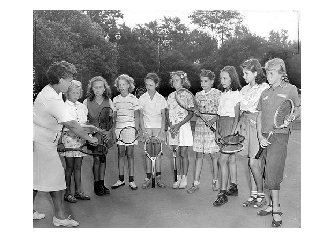

(406, 500, 3)
(406, 500, 3)


In [15]:
import os
import numpy as np
img_dir = '/home/hongshan/data/train2017'
I = io.imread(os.path.join(img_dir, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()
print(I.shape)
a = np.array(I)
print(a.shape)

(406, 500)


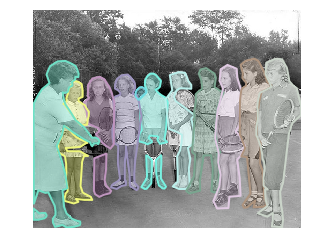

In [12]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds=coco.getAnnIds(imgIds=img['id'], 
                      catIds=catIds, iscrowd=False)
anns=coco.loadAnns(annIds)
coco.showAnns(anns)


# show dim of mask of one instance
mask = coco.annToMask(anns[0])
print(mask.shape)

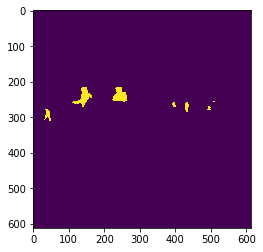

In [7]:
# get binary mask
mask = []
for i in range(len(anns)):
    mask.append(coco.annToMask(anns[i]))

mask = sum(mask)

plt.imshow(mask)

In [63]:
import torchvision.datasets as dsets

# need to pad input into same dim
# mask should correspond to input dim


def mask_psn_instances(anns):
    psn_instances=[]
    for ann in anns:
        if ann['category_id']==1:
            psn_instance.append(ann)
    return psn_instances

data=dsets.CocoDetection(img_dir, annFile, 
                         target_transform=get_psn_instances)


loading annotations into memory...
Done (t=19.94s)
creating index...
index created!


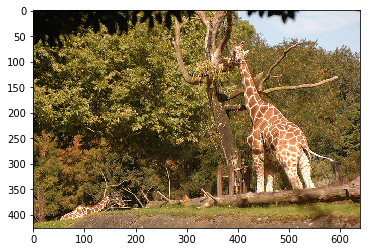

In [64]:
img, tg = data[1]
plt.imshow(img)
for ann in tg:
    print(ann['category_id'])


In [59]:
# get binary mask
mask = []
for i in range(len(tg)):
    mask.append(coco.annToMask(tg[i]))

#mask = sum(mask)

#plt.imshow(mask)

In [60]:
len(mask)

2